# Random Forest Model for Predicting Stock Market Price Direction

This project implements a Random Forest model to predict the direction of stock market prices, inspired by the methodology described in the paper [*Predicting the direction of stock market prices using random forest (Khaidem, Saha, Roy Dey 2016)*](https://arxiv.org/pdf/1605.00003).

## Data Collection

In [1103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split

df = pd.DataFrame(yf.download("AAPL", period='1y')).reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-09,176.809998,179.050003,175.800003,178.990005,178.078751,42390800
2023-10-10,178.100006,179.720001,177.949997,178.389999,177.481796,43698000
2023-10-11,178.199997,179.850006,177.600006,179.800003,178.884628,47551100
2023-10-12,180.070007,182.339996,179.039993,180.710007,179.789993,56743100
2023-10-13,181.419998,181.929993,178.139999,178.850006,177.939484,51427100


### Exponential Smoothing

The smoothing formula used for the features is as follows:

$$
S_0 = Y_0
$$

$$
\text{for} \ t > 0, \ S_t = \alpha \cdot Y_t + (1 - \alpha) \cdot S_{t-1}
$$

In [1104]:
def smooth(Y, a):
    S = np.zeros(len(Y))

    S[0] = Y[0]

    for t in range(1, len(Y)):
        S[t] = a * Y[t] + (1 - a) * S[t-1]

    return S

### Features
#### RSI
The RSI is calculated as follows:
$$
RSI = 100 - \frac{100}{1 + RS}
$$
$$
RS = \frac{\text{Average Gain Over past 14 days}}{\text{Average Loss Over past 14 days}}
$$

In [1105]:
def rsi(data, window=14):
    delta = data['Close'].diff(1)
    
    gains, losses = delta.where(delta > 0, 0), -delta.where(delta < 0, 0)

    avg_gain, avg_loss = np.mean(gains.iloc[1:window+1]), np.mean(losses.iloc[1:window+1])

    rsi_values  = ([np.nan] * window)
    if avg_loss == 0:
        rsi_values.append(100)
    else: 
        rsi_values.append((100 - (100 / (1 + (avg_gain / avg_loss)))))

    for i in range(window + 1, len(delta)):
        avg_gain, avg_loss = (avg_gain * (window-1) + gains.iloc[i]) / window, (avg_loss * (window-1) + losses.iloc[i]) / window

        rsi_values.append(100 - (100 / (1 + (avg_gain/avg_loss))))

    return rsi_values


df['RSI'] = rsi(df)

df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI
Date,,,,,,,
2023-10-09,176.809998,179.050003,175.800003,178.990005,178.078751,42390800,NaN
2023-10-10,178.100006,179.720001,177.949997,178.389999,177.481796,43698000,NaN
2023-10-11,178.199997,179.850006,177.600006,179.800003,178.884628,47551100,NaN
2023-10-12,180.070007,182.339996,179.039993,180.710007,179.789993,56743100,NaN
2023-10-13,181.419998,181.929993,178.139999,178.850006,177.939484,51427100,NaN


#### Stochastic Oscillator
The Stochastic Oscillator is calculated as follows:
$$
\%K = \frac{(C - L_{14})}{(H_{14} - L_{14})} \times 100
$$
Where:
- $C$ is the most recent closing price
- $L_{14}$ is the lowest price traded of the 14 previous trading sessions
- $H_{14}$ is the highest price traded during the same 14-day period

In [1106]:
def stochastic_oscillator():
    k = []
    for i in range(len(df['Close'])):
        if (14+i) < len(df['Close']):
            k.append(100 * (df['Close'].iloc[i] - min(df['Low'].iloc[i:14+i])) / (max(df['High'].iloc[i:14+i]) - min(df['Low'].iloc[:14+i])))
        else:
            k.append(100 * (df['Close'].iloc[i] - min(df['Low'].iloc[i:len(df['Close'])])) / (max(df['High'].iloc[i:len(df['Close'])]) - min(df['Low'].iloc[i:len(df['Close'])])))
    return k

df['SO'] = smooth(stochastic_oscillator(), 0.7)

df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SO
Date,,,,,,,,
2023-10-09,176.809998,179.050003,175.800003,178.990005,178.078751,42390800,NaN,79.904072
2023-10-10,178.100006,179.720001,177.949997,178.389999,177.481796,43698000,NaN,77.384550
2023-10-11,178.199997,179.850006,177.600006,179.800003,178.884628,47551100,NaN,82.549525
2023-10-12,180.070007,182.339996,179.039993,180.710007,179.789993,56743100,NaN,87.920269
2023-10-13,181.419998,181.929993,178.139999,178.850006,177.939484,51427100,NaN,83.116602


#### Williams %R

Williams %R is calculated as follows:
$$
\%R = \frac{(H_{14} - C)}{(H_{14} - L_{14})} \times -100
$$
Where:
- $C$ is the closing price
- $H_{14}$ is the highest price over the past 14 days
- $L_{14}$ is the lowest price over the past 14 days

In [1107]:
def williams():
    w = []
    for i in range(len(df['Close'])):
        if (14+i) < len(df['Close']):
            w.append((-100) * (max(df['High'].iloc[i:14+i]) - df['Close'].iloc[i]) / (max(df['High'].iloc[i:14+i]) - min(df['Low'].iloc[:14+i])))
        else:
            w.append((-100) * (max(df['High'].iloc[i:len(df['Close'])]) - df['Close'].iloc[i]) / (max(df['High'].iloc[i:len(df['Close'])]) - min(df['Low'].iloc[i:len(df['Close'])])))
    return w

df['Williams'] = smooth(williams(), 0.7)

df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SO,Williams
Date,,,,,,,,,
2023-10-09,176.809998,179.050003,175.800003,178.990005,178.078751,42390800,NaN,79.904072,-20.095928
2023-10-10,178.100006,179.720001,177.949997,178.389999,177.481796,43698000,NaN,77.384550,-22.615450
2023-10-11,178.199997,179.850006,177.600006,179.800003,178.884628,47551100,NaN,82.549525,-17.450475
2023-10-12,180.070007,182.339996,179.039993,180.710007,179.789993,56743100,NaN,87.920269,-12.079731
2023-10-13,181.419998,181.929993,178.139999,178.850006,177.939484,51427100,NaN,83.116602,-16.883398


#### MACD

MACD is caluclated as follows:
$$
\text{MACD} = \text{EMA}_{12} - \text{EMA}_{26}
$$

$$
\text{Signal Line} = \text{EMA}_{9}(\text{MACD})
$$
Where:
- $\text{EMA}_{12}$ is the 12-day Exponential Moving Average
- $\text{EMA}_{26}$ is the 26-day Exponential Moving Average
- $\text{EMA}_{9}$ is the 9-day Exponential Moving Average

In [1108]:
def macd():
    df['EMA_12'], df['EMA_26'] = df['Close'].ewm(span=12, adjust=False).mean(), df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = smooth(df['EMA_12'] - df['EMA_26'], 0.7)

    df['Signal Line'] = smooth(df['MACD'].ewm(span=9, adjust=False).mean(), 0.7)

macd()

df.head()

/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_41194/1617978800.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S[0] = Y[0]
/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_41194/1617978800.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S[t] = a * Y[t] + (1 - a) * S[t-1]
/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_41194/1617978800.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S[0] 

,Open,High,Low,Close,Adj Close,Volume,RSI,SO,Williams,EMA_12,EMA_26,MACD,Signal Line
Date,,,,,,,,,,,,,
2023-10-09,176.809998,179.050003,175.800003,178.990005,178.078751,42390800,NaN,79.904072,-20.095928,178.990005,178.990005,0.000000,0.000000
2023-10-10,178.100006,179.720001,177.949997,178.389999,177.481796,43698000,NaN,77.384550,-22.615450,178.897697,178.945561,-0.033505,-0.004691
2023-10-11,178.199997,179.850006,177.600006,179.800003,178.884628,47551100,NaN,82.549525,-17.450475,179.036513,179.008853,0.009311,-0.003856
2023-10-12,180.070007,182.339996,179.039993,180.710007,179.789993,56743100,NaN,87.920269,-12.079731,179.293974,179.134864,0.114170,0.012868
2023-10-13,181.419998,181.929993,178.139999,178.850006,177.939484,51427100,NaN,83.116602,-16.883398,179.225671,179.113763,0.112586,0.030842


#### Price ROC
The Price Rate of Change is calculated as follows:
$$
\text{Price ROC} = \frac{C_t - C_{t-n}}{C_{t-n}} \times 100
$$
Where:
- ${C_t}$ is the closing price of the current day
- ${C_{t-n}}$ is the closing price of the previous day
- $n$ is the number of days


In [1109]:
def proc(n = 14):
    p = []
    for i in range(len(df['Close'])):
        if i-n >= 0:
            p.append((df['Close'][i] - df['Close'][i-n]) / df['Close'][i-n])
            
    return ([np.nan] * n) + smooth(p, 0.7).tolist()

df['ROC'] = proc()

df.head()

/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_41194/1353006939.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p.append((df['Close'][i] - df['Close'][i-n]) / df['Close'][i-n])


,Open,High,Low,Close,Adj Close,Volume,RSI,SO,Williams,EMA_12,EMA_26,MACD,Signal Line,ROC
Date,,,,,,,,,,,,,,
2023-10-09,176.809998,179.050003,175.800003,178.990005,178.078751,42390800,NaN,79.904072,-20.095928,178.990005,178.990005,0.000000,0.000000,NaN
2023-10-10,178.100006,179.720001,177.949997,178.389999,177.481796,43698000,NaN,77.384550,-22.615450,178.897697,178.945561,-0.033505,-0.004691,NaN
2023-10-11,178.199997,179.850006,177.600006,179.800003,178.884628,47551100,NaN,82.549525,-17.450475,179.036513,179.008853,0.009311,-0.003856,NaN
2023-10-12,180.070007,182.339996,179.039993,180.710007,179.789993,56743100,NaN,87.920269,-12.079731,179.293974,179.134864,0.114170,0.012868,NaN
2023-10-13,181.419998,181.929993,178.139999,178.850006,177.939484,51427100,NaN,83.116602,-16.883398,179.225671,179.113763,0.112586,0.030842,NaN


#### On Balance Volume

On Balance Volume is calculated as follows:
$$
OBV(t) =
\begin{cases} 
OBV(t-1) + Vol(t) & \text{if } C(t) > C(t-1) \\
OBV(t-1) - Vol(t) & \text{if } C(t) < C(t-1) \\
OBV(t-1) & \text{if } C(t) = C(t-1)
\end{cases}
$$
Where:
- $OBV(t)$ is the On Balance Volume at time $t$
- $Vol(t)$ is the volume at time $t$
- $C(t)$ is the closing price at time $t$

In [1110]:
def obv():
    o = [0]
    for i in range(1, len(df['Close'])):
        if df['Close'][i] > df['Close'][i-1]:
            o.append(o[i-1] + df['Volume'][i])
        elif df['Close'][i] < df['Close'][i-1]:
            o.append(o[i-1] - df['Volume'][i])
        else:
            o.append(o[i-1])
    return o

df['OBV'] = smooth(obv(), 0.7)

df.head()

/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_41194/36840779.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Close'][i] > df['Close'][i-1]:
/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_41194/36840779.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['Close'][i] < df['Close'][i-1]:
/var/folders/qy/v3h3mf7s06910rb44k37m4vr0000gn/T/ipykernel_41194/36840779.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

,Open,High,Low,Close,Adj Close,Volume,RSI,SO,Williams,EMA_12,EMA_26,MACD,Signal Line,ROC,OBV
Date,,,,,,,,,,,,,,,
2023-10-09,176.809998,179.050003,175.800003,178.990005,178.078751,42390800,NaN,79.904072,-20.095928,178.990005,178.990005,0.000000,0.000000,NaN,0.0
2023-10-10,178.100006,179.720001,177.949997,178.389999,177.481796,43698000,NaN,77.384550,-22.615450,178.897697,178.945561,-0.033505,-0.004691,NaN,-30588600.0
2023-10-11,178.199997,179.850006,177.600006,179.800003,178.884628,47551100,NaN,82.549525,-17.450475,179.036513,179.008853,0.009311,-0.003856,NaN,-6479410.0
2023-10-12,180.070007,182.339996,179.039993,180.710007,179.789993,56743100,NaN,87.920269,-12.079731,179.293974,179.134864,0.114170,0.012868,NaN,40473517.0
2023-10-13,181.419998,181.929993,178.139999,178.850006,177.939484,51427100,NaN,83.116602,-16.883398,179.225671,179.113763,0.112586,0.030842,NaN,18560425.1


#### Feature Summary

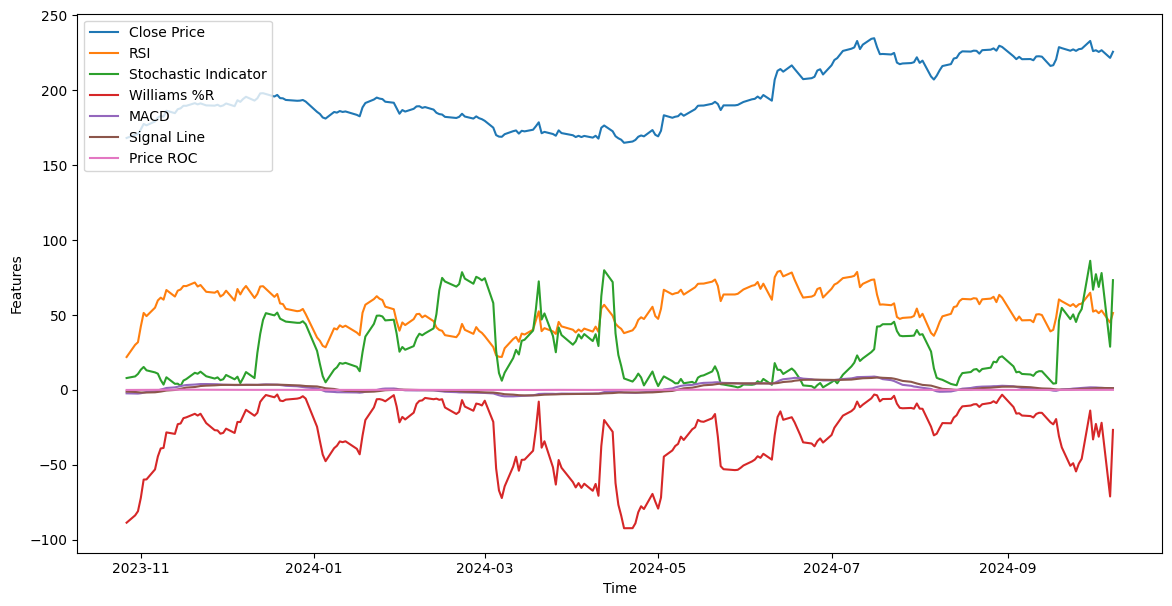

In [1111]:
df.dropna(inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['RSI'], label='RSI')
plt.plot(df['SO'], label='Stochastic Indicator')
plt.plot(df['Williams'], label='Williams %R')
plt.plot(df['MACD'], label='MACD')
plt.plot(df['Signal Line'], label='Signal Line')
plt.plot(df['ROC'], label='Price ROC')
plt.xlabel('Time')
plt.ylabel('Features')
plt.legend()

#### Splitting Data

In [1112]:
n = 90

df['Target'] = (df['Close'].shift(-n) > df['Close']).astype(int).replace(0, -1)

X, y = df[['RSI', 'SO', 'Williams', 'MACD', 'ROC', 'OBV']], df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest Implementation

In [1113]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=65, random_state=42), n_estimators=45, max_samples=0.8, random_state=42)
model.fit(X_train, y_train)

BaggingClassifier(estimator=RandomForestClassifier(n_estimators=65,
                                                   random_state=42),
                  max_samples=0.8, n_estimators=45, random_state=42)

#### Model Evaluation

In [1114]:
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.93      0.93        28
           1       0.90      0.90      0.90        20

    accuracy                           0.92        48
   macro avg       0.91      0.91      0.91        48
weighted avg       0.92      0.92      0.92        48

Confusion Matrix:
 [[26  2]
 [ 2 18]]


## Trading Strategy

### Backtesting

Strategy Return: 0.13
Sharpe: 5.08


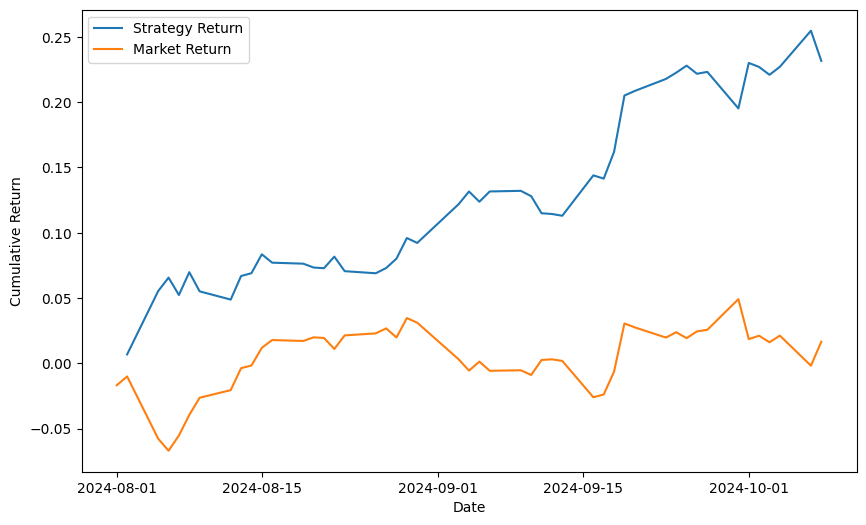

In [1115]:
y_pred = y_pred[::-1]

df['Predictions'] = [np.nan] * (len(df['Close']) - len(y_pred)) + y_pred.tolist()
df['Market_Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

df['Return'] = df['Market_Return'] * df['Predictions'].shift(1)

df['Cumulative_Return'] = (1 + df['Return']).cumprod() - 1
df['Cumulative_Market_Return'] = (1 + df['Market_Return']).cumprod() - 1

print(f"Strategy Return: {df['Cumulative_Return'].mean():.2f}")
print(f"Sharpe: {((df['Return'].mean() - (0.01/252)) / df['Return'].std()) * np.sqrt(252):.2f}")

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Cumulative_Return'], label='Strategy Return')
plt.plot(df.index, df['Cumulative_Market_Return'], label='Market Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()